# Instrumento a analizar: Acciones de Nvidia Corporation (NVDA) de NasdaqGS.

## Sobre Nvidia Corporation:

# Cargando las librerías necesarias

In [ ]:
# Cargando librerías:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.set_config_file(offline=True)
import yfinance as yf
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from scipy.stats import shapiro
from scipy.stats import t
import scipy.stats as stats
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import norm, t



# Importando los datos históricos del activo

In [ ]:
# Importamos los históricos del activo desde 2010
df = yf.download('NVDA', start='2010-01-01', progress=False)['Close']
df

Date
2010-01-04      4.622500
2010-01-05      4.690000
2010-01-06      4.720000
2010-01-07      4.627500
2010-01-08      4.637500
                 ...    
2024-04-04    859.049988
2024-04-05    880.080017
2024-04-08    871.330017
2024-04-09    853.539978
2024-04-10    870.390015
Name: Close, Length: 3591, dtype: float64

# Cálculo de los rendimientos diarios

In [ ]:
# Rendimientos diarios (log retornos)
rendim_diarios = np.log(df).diff().dropna()
rendim_diarios.head(5)



Date
2010-01-05    0.014497
2010-01-06    0.006376
2010-01-07   -0.019792
2010-01-08    0.002159
2010-01-11   -0.014115
Name: Close, dtype: float64

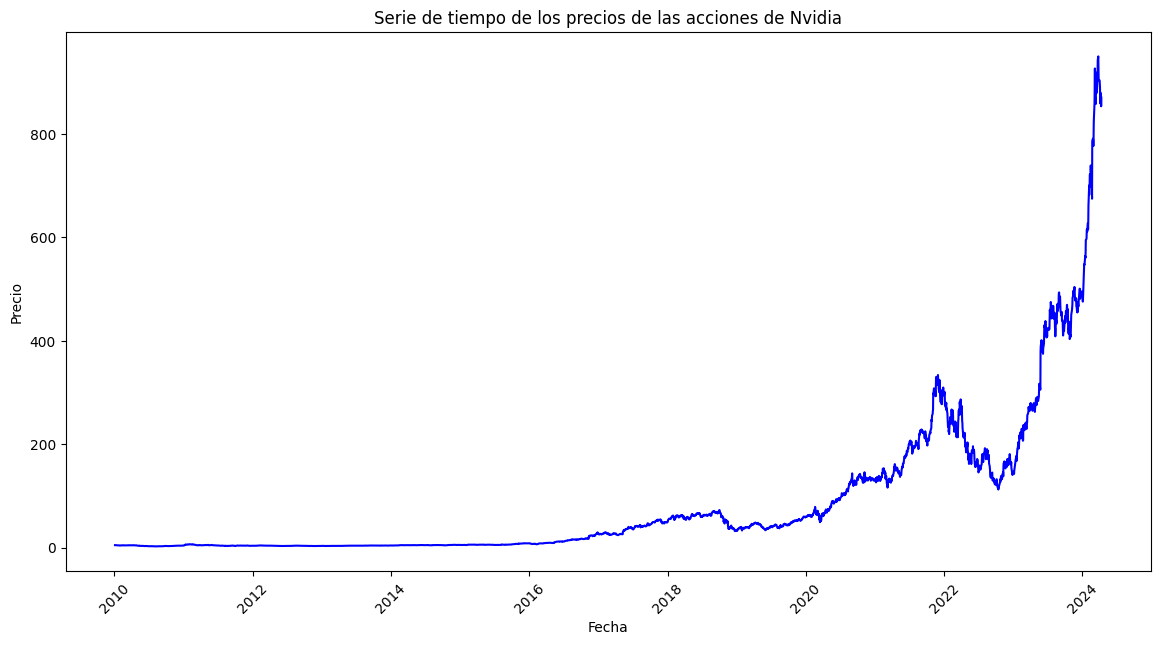

In [ ]:
# Grafica de los datos históricos

plt.figure(figsize=(14,7))
plt.plot(df, linestyle="-", color = "blue")
plt.title("Serie de tiempo de los precios de las acciones de Nvidia")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.xticks(rotation=45)
plt.show()

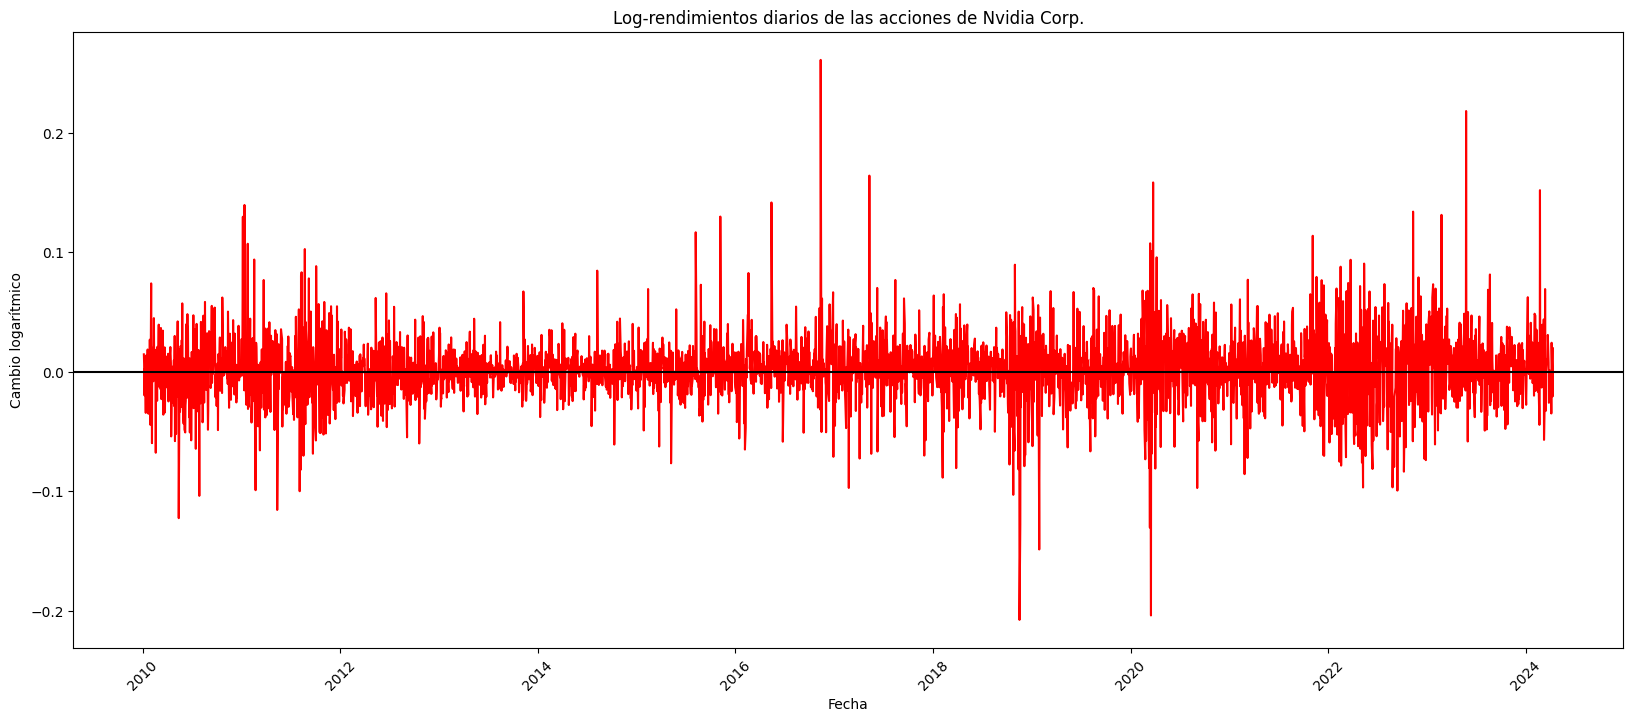

In [ ]:
# Gráfica de los rendimientos diarios

plt.figure(figsize=(20,8))
plt.plot(rendim_diarios, linestyle="-", color = "r")
plt.title("Log-rendimientos diarios de las acciones de Nvidia Corp.")
plt.axhline(y=0, color = "black")
plt.xlabel("Fecha")
plt.ylabel("Cambio logarítmico")
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Media, sesgo y exceso de curtosis
media = rendim_diarios.mean()
curtosis = kurtosis(rendim_diarios)
sesgo = skew(rendim_diarios)

df_mcs = (media,curtosis,sesgo)
print(df_mcs)

(0.0014590545214468998, 7.253976316574235, 0.2669175163487829)


# Cálculo del VaR y ES
## Se usarán $ \alpha $ = 0.95, 0.975, 0.99 y los siguientes métodos:
* ### Método histórico.
* ### Paramétricamente se aproximarán mediante una distribución normal y una t de Student.
* ### Por último, se aproximarán también mediante simulación Montecarlo.

In [ ]:
# Método Paramétrico

# Parámetros
media = np.mean(rendim_diarios)
desv_est = np.std(rendim_diarios)

# Niveles de confianza
alphas = [0.95, 0.975, 0.99]
grados_libertad = len(rendim_diarios) - 1

# VaR y ES para distribución normal
for alpha in alphas:
    VaR_norm = norm.ppf(1-alpha, media, desv_est)
    ES_norm = media - desv_est * norm.pdf(norm.ppf(alpha)) / (1 - alpha)
    print(f'Normal - Alpha {alpha}: VaR {VaR_norm:.4f}, ES {ES_norm:.4f}')

# VaR y ES para distribución t-Student
for alpha in alphas:
    VaR_t = t.ppf(1-alpha, grados_libertad, media, desv_est)
    ES_t = media - desv_est * t.pdf(t.ppf(alpha, grados_libertad), grados_libertad) / (1 - alpha) * (grados_libertad + (t.ppf(alpha, grados_libertad))**2) / (grados_libertad-1)
    print(f't-Student - Alpha {alpha}: VaR {VaR_t:.4f}, ES {ES_t:.4f}')

Normal - Alpha 0.95: VaR -0.0448, ES -0.0566
Normal - Alpha 0.975: VaR -0.0537, ES -0.0643
Normal - Alpha 0.99: VaR -0.0640, ES -0.0735
t-Student - Alpha 0.95: VaR -0.0448, ES -0.0566
t-Student - Alpha 0.975: VaR -0.0537, ES -0.0643
t-Student - Alpha 0.99: VaR -0.0640, ES -0.0736


In [ ]:
# Método Histórico

for alpha in alphas:
    VaR_hist = np.percentile(rendim_diarios, (1-alpha)*100)
    ES_hist = rendim_diarios[rendim_diarios <= VaR_hist].mean()
    print(f'Histórico - Alpha {alpha}: VaR {VaR_hist:.4f}, ES {ES_hist:.4f}')

Histórico - Alpha 0.95: VaR -0.0421, ES -0.0625
Histórico - Alpha 0.975: VaR -0.0561, ES -0.0772
Histórico - Alpha 0.99: VaR -0.0723, ES -0.0981


In [ ]:
# Simulación de Montecarlo

# Parámetros para la simulación
num_simulaciones = 10000
duracion = 1  # Para rendimientos diarios

# Simulaciones de Monte Carlo
simulaciones = np.random.normal(media, desv_est, (num_simulaciones, duracion))

for alpha in alphas:
    VaR_mc = np.percentile(simulaciones, (1-alpha)*100)
    ES_mc = simulaciones[simulaciones <= VaR_mc].mean()
    print(f'Monte Carlo - Alpha {alpha}: VaR {VaR_mc:.4f}, ES {ES_mc:.4f}')

Monte Carlo - Alpha 0.95: VaR -0.0452, ES -0.0573
Monte Carlo - Alpha 0.975: VaR -0.0536, ES -0.0655
Monte Carlo - Alpha 0.99: VaR -0.0657, ES -0.0761


# Cálculo de VaR y ES a 252 días mediante el método *Rolling Windows* ($\alpha$=0.95, 0.99)

Creamos al dataframe returns, cuyo resultado serán los retornos diarios del activo

In [ ]:
# Rolling Windows
returns = df.pct_change().dropna()
returns.sample(n = 10).sort_index()


Date
2013-08-23    0.000000
2014-01-21    0.003752
2014-06-24   -0.015500
2015-04-06    0.028965
2015-04-09    0.023161
2016-01-05    0.016064
2016-02-03    0.004989
2018-07-13   -0.007603
2019-01-11    0.024788
2019-02-22    0.021955
Name: Close, dtype: float64

## Con confianza del 95%

### Cálculo del VaR y ES

Ahora, obtendremos la media y varianza de los retornos a 252 días, para después calcular el VaR asumiendo una distribución normal.
Recordemos que el VaR para una función de riesgo $L$ con distribución normal con media $\mu$ y varianza $\sigma^2$ se define como:

$$ VaR_L^{0.95} = \mu + |\sigma|\Phi(0.05)^{-1} $$

Para el ES, este se define como:

$$ES_L^{\alpha} = \frac{1}{ 1 - \alpha} \int\limits_{1-\alpha}^{\infty}VaR_L^x \mathrm{dx}$$

Asumiendo una distribución normal (y reparametrizando para la cola izquierda), sabemos que
$$ES_L^{\alpha} = -\left(\mu + \frac{\sigma}{\alpha} \phi\left( \Phi^{-1}(\alpha) \right)\right) $$

Mediante las funciones norm, pdf y ppf de scipty calcularemos dichos valores.



In [ ]:
# Calculemos la media y la varianza de los retornos durante los últimos 252 días:

media_retornos = returns.rolling(window = 252).mean()
sd_retornos = returns.rolling(window = 252).std()

# Ahora, obtengamos el VaR 95% de los retornos
var_95_rolling = norm.ppf(0.05, media_retornos, sd_retornos)

# Como porcentajes
var_95_rolling_percent = (var_95_rolling*100).round(5)

# Ahora, obtengamos el ES 95% de los retornos
ES_95_rolling =  -(media_retornos + (sd_retornos/0.05)*norm.pdf(norm.ppf(0.95, loc = 0, scale = 1), loc = 0, scale = 1))

# Como porcentajes
ES_95_rolling_percent = (ES_95_rolling*100).round(5)

# Agreguémoslo a un dataframe
risk_95_rolling = pd.DataFrame({"Fecha":returns.index, "VaR_95":var_95_rolling_percent, "ES_95":ES_95_rolling_percent})
risk_95_rolling.set_index("Fecha", inplace = True)

risk_95_rolling.sample(n=10)


,VaR_95,ES_95
Fecha,,
2022-04-21,-5.11627,-6.80564
2015-10-06,-3.19944,-4.37309
2010-01-14,NaN,NaN
2018-10-08,-3.43513,-4.70451
2013-04-08,-3.26461,-3.96371
2019-06-18,-5.47327,-6.49216
2023-05-26,-5.85348,-8.24237
2010-12-29,NaN,NaN
2020-04-29,-5.49729,-7.47961


### Gráfica del VaR y cVaR 95% paramétrico contra los retornos diarios


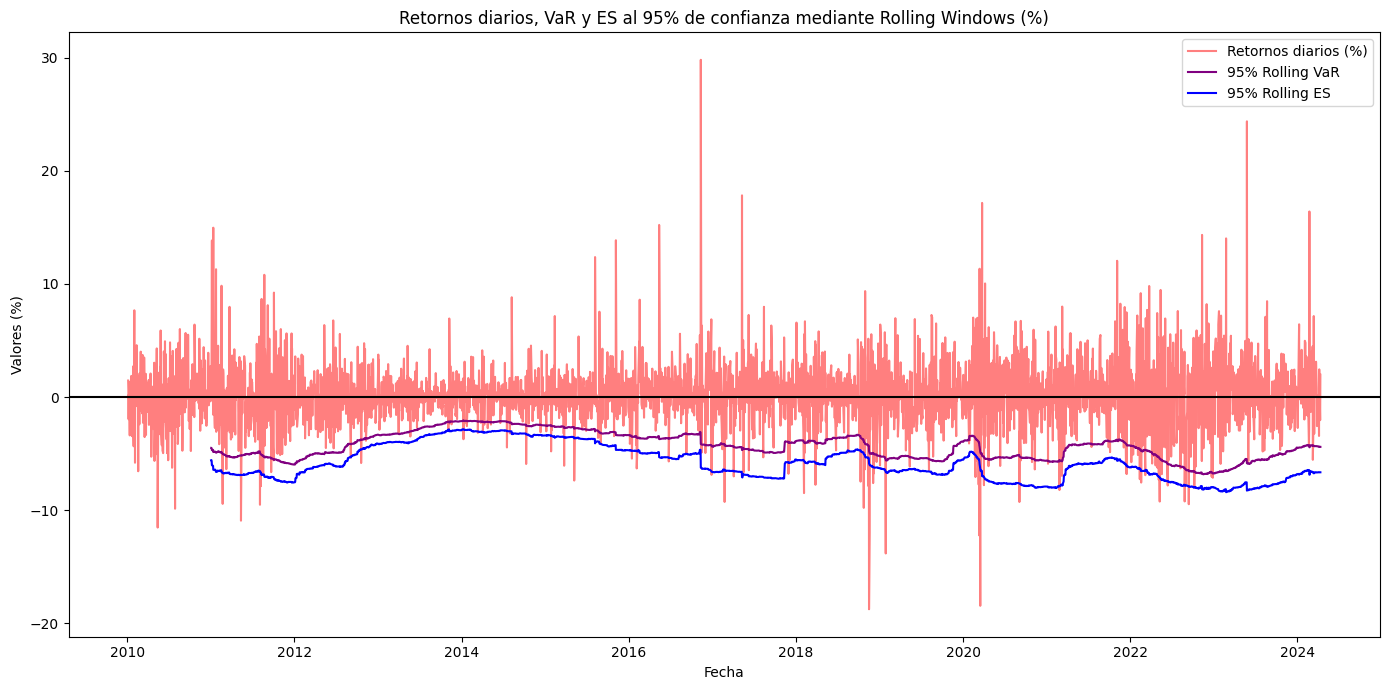

In [ ]:
plt.figure(figsize=(14, 7))

# Gráfica de los retornos diarios, convirtiéndolos a porcentaje
plt.plot(returns.index, returns * 100, label='Retornos diarios (%)', color='red', alpha=0.5)

# Agregamos el VaR calculado mediante rolling windows
plt.plot(risk_95_rolling.index, risk_95_rolling['VaR_95'], label='95% Rolling VaR', color='purple')

# Agregamos el ES calculado mediante rolling windows
plt.plot(risk_95_rolling.index, risk_95_rolling["ES_95"], label = "95% Rolling ES", color = "blue")

# Agregamos linea horizontal en el cero
plt.axhline(y = 0, color = "black")

# Add a title and axis labels
plt.title('Retornos diarios, VaR y ES al 95% de confianza mediante Rolling Windows (%)')
plt.xlabel('Fecha')
plt.ylabel('Valores (%)')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Con confianza del 99%

Se seguirá el mismo procedimiento que en el caso donde $\alpha = 95\% $, cambiando únicamente $95\%$ por $99\%$.

In [ ]:
# Calculemos la media y la varianza de los retornos durante los últimos 252 días:

media_retornos = returns.rolling(window = 252).mean()
sd_retornos = returns.rolling(window = 252).std()

# Ahora, obtengamos el VaR 95% de los retornos
var_99_rolling = norm.ppf(0.01, media_retornos, sd_retornos)

# Como porcentajes
var_99_rolling_percent = (var_99_rolling*100).round(5)

# Ahora, obtengamos el ES 95% de los retornos
ES_99_rolling =  -(media_retornos + (sd_retornos/0.01)*norm.pdf(norm.ppf(0.99, loc = 0, scale = 1), loc = 0, scale = 1))

# Como porcentajes
ES_99_rolling_percent = (ES_99_rolling*100).round(5)

# Agreguémoslo a un dataframe
risk_99_rolling = pd.DataFrame({"Fecha":returns.index, "VaR_99":var_99_rolling_percent, "ES_99":ES_99_rolling_percent})
risk_99_rolling.set_index("Fecha", inplace = True)

risk_99_rolling.sample(n=10).sort_index()


,VaR_99,ES_99
Fecha,,
2010-10-13,NaN,NaN
2010-11-03,NaN,NaN
2011-02-04,-6.87511,-8.36629
2012-12-11,-4.90105,-5.53424
2015-08-05,-4.02224,-4.77154
2016-07-28,-5.23947,-6.94681
2018-09-05,-4.92851,-6.14042
2019-04-23,-7.33264,-8.35529
2021-03-24,-6.53253,-8.18058


### Gráfica del VaR y cVaR paramétricos al 99% de confianza contra los retornos diarios

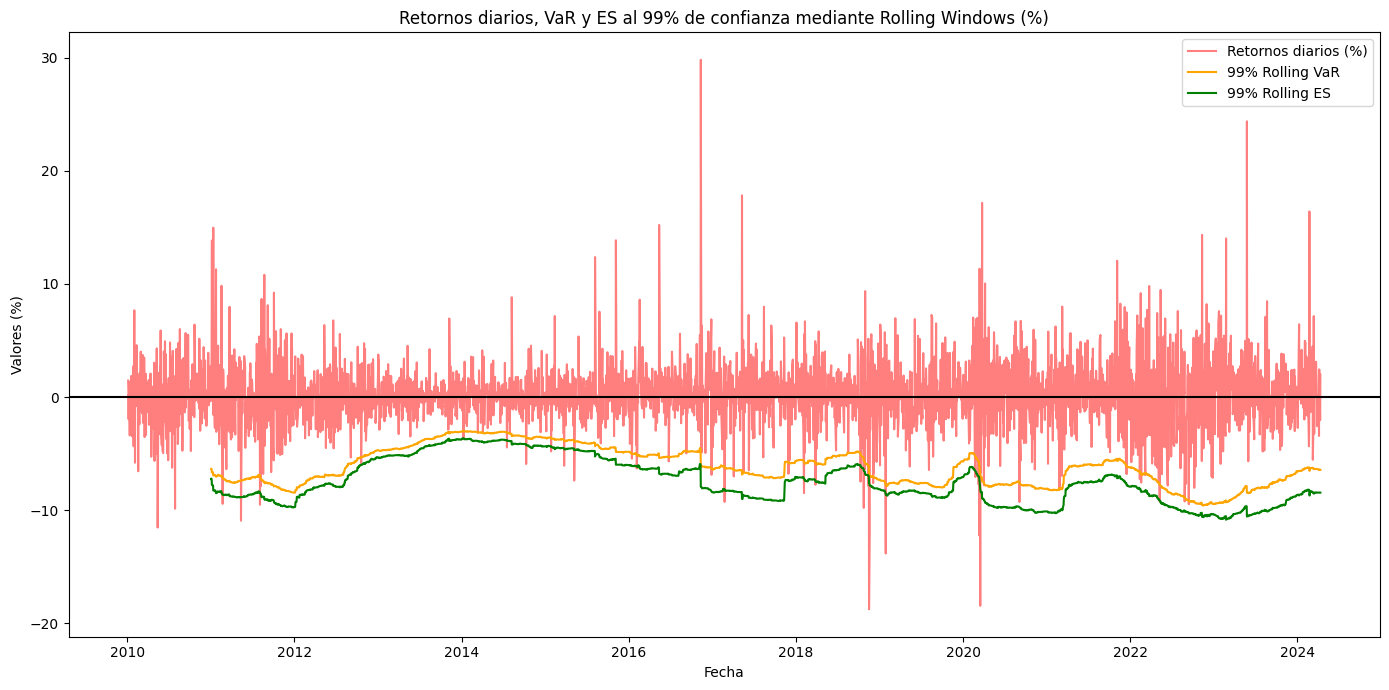

In [ ]:
plt.figure(figsize=(14, 7))

# Gráfica de los retornos diarios, convirtiéndolos a porcentaje
plt.plot(returns.index, returns * 100, label='Retornos diarios (%)', color='red', alpha=0.5)

# Agregamos el VaR calculado mediante rolling windows
plt.plot(risk_99_rolling.index, risk_99_rolling['VaR_99'], label='99% Rolling VaR', color='orange')

# Agregamos el ES calculado mediante rolling windows
plt.plot(risk_99_rolling.index, risk_99_rolling["ES_99"], label = "99% Rolling ES", color = "green")

# Agregamos linea horizontal en el cero
plt.axhline(y = 0, color = "black")

# Add a title and axis labels
plt.title('Retornos diarios, VaR y ES al 99% de confianza mediante Rolling Windows (%)')
plt.xlabel('Fecha')
plt.ylabel('Valores (%)')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

## Gráfica con VaR y ES al 95% y 99% de confianza

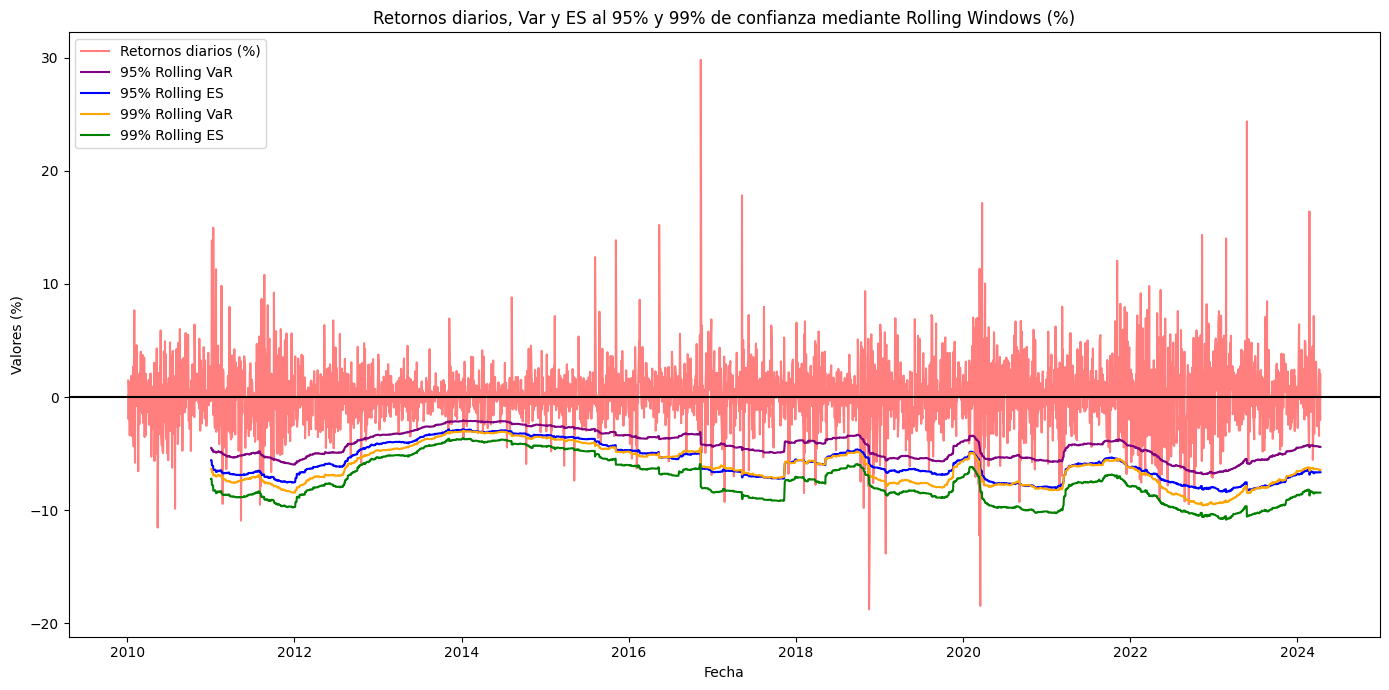

In [ ]:
plt.figure(figsize=(14, 7))

# Gráfica de los retornos diarios, convirtiéndolos a porcentaje
plt.plot(returns.index, returns * 100, label='Retornos diarios (%)', color='red', alpha=0.5)

# Agregamos el VaR 95% calculado mediante rolling windows
plt.plot(risk_95_rolling.index, risk_95_rolling['VaR_95'], label='95% Rolling VaR', color='purple')

# Agregamos el ES 95% calculado mediante rolling windows
plt.plot(risk_95_rolling.index, risk_95_rolling["ES_95"], label = "95% Rolling ES", color = "blue")

# Agregamos el VaR 99% calculado mediante rolling windows
plt.plot(risk_99_rolling.index, risk_99_rolling['VaR_99'], label='99% Rolling VaR', color='orange')

# Agregamos el ES 95% calculado mediante rolling windows
plt.plot(risk_99_rolling.index, risk_99_rolling["ES_99"], label = "99% Rolling ES", color = "green")

# Agregamos linea horizontal en el cero
plt.axhline(y = 0, color = "black")

# Add a title and axis labels
plt.title('Retornos diarios, Var y ES al 95% y 99% de confianza mediante Rolling Windows (%)')
plt.xlabel('Fecha')
plt.ylabel('Valores (%)')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

# Eficiencia y violaciones de las estimaciones calculadas mediante *Rolling Windows*

In [ ]:
# Eficiencia de Rolling Windows
#Para calcular el numero de veces que la perdida fue superior a la estimacion

In [ ]:
#Con 99% de confianza
contador_violaciones_var99 = 0
for valor_retorno, valor_var99 in zip(returns, var_99_rolling):
    if valor_retorno < valor_var99:
        contador_violaciones_var99 +=1

print("Hay", contador_violaciones_var99, "violaciones con respecto al VaR al 99% ")


contador_violaciones_ES99 = 0
for valor_retorno, valor_ES99 in zip(returns, ES_99_rolling):
    if valor_retorno < valor_ES99:
        contador_violaciones_ES99 +=1

print("Hay", contador_violaciones_ES99, "violaciones con respecto al ES99 al 99%")

#Con 95% de confianza
contador_violaciones_var95=0
for valor_retorno, valor_var95 in zip(returns, var_95_rolling):
    if valor_retorno < valor_var95:
        contador_violaciones_var95 +=1

print("Hay", contador_violaciones_var95, "violaciones con respecto al VaR al 95%")

contador_violaciones_ES95 = 0
for valor_retorno,valor_ES95 in zip(returns,ES_95_rolling):
  if valor_retorno < valor_ES95:
    contador_violaciones_ES95 +=1

print("Hay", contador_violaciones_ES95, "violaciones con respecto al ES al 95%")

Hay 46 violaciones con respecto al VaR al 99% 
Hay 24 violaciones con respecto al ES99 al 99%
Hay 148 violaciones con respecto al VaR al 95%
Hay 54 violaciones con respecto al ES al 95%


In [ ]:
porcentaje_var99 = (contador_violaciones_var99 / len(returns))*100
porcentaje_ES99 = (contador_violaciones_ES99 / len(returns))*100
porcentaje_var95 = (contador_violaciones_var95 / len(returns))*100
porcentaje_ES95= (contador_violaciones_ES95 / len(returns))*100

#En una tabla reportamos el numero de violaciones, el porcentaje de la muestra para cada nivel de confianza asi como tambien la medida del riesgo
datos = {
    'Numero de violaciones': [contador_violaciones_var99, contador_violaciones_ES99, contador_violaciones_var95,contador_violaciones_ES95],
    'Porcentaje': [porcentaje_var99, porcentaje_ES99, porcentaje_var95, porcentaje_ES95]
}
tabla = pd.DataFrame(datos, index = ["VaR99","ES99","VaR95","ES95"])

# Mostrar la tabla
print(tabla)

       Numero de violaciones  Porcentaje
VaR99                     46    1.281337
ES99                      24    0.668524
VaR95                    148    4.122563
ES95                      54    1.504178


# Cálculo del VaR mediante la volatilidad móvil

In [ ]:
#La desviacion estandar para Rooling Window
rolling_std = returns.rolling(window=252).std()

In [ ]:
alpha_levels_c = [0.05]
sigma = 0.01
VaR_results_alphac = {}
for alpha in alpha_levels_c:
    q_alpha = np.percentile(np.random.normal(0, 1, len(returns)), 100 * (1 - alpha))
    VaR_results_alphac[alpha] = q_alpha * rolling_std
    VaR_Clean_c = VaR_results_alphac[alpha]
print(VaR_Clean_c)

Date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2024-04-04    0.050526
2024-04-05    0.050508
2024-04-08    0.050457
2024-04-09    0.050531
2024-04-10    0.050530
Name: Close, Length: 3590, dtype: float64


In [ ]:
alpha_levels_u = [0.01]
sigma = 0.01
VaR_results_alphau = {}
for alpha in alpha_levels_u:
    q_alpha = np.percentile(np.random.normal(0, 1, len(returns)), 100 * (1 - alpha))
    VaR_results_alphau[alpha] = q_alpha * rolling_std
    VaR_Clean_u = VaR_results_alphau[alpha]
print(VaR_Clean_u)

Date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2024-04-04    0.068834
2024-04-05    0.068809
2024-04-08    0.068740
2024-04-09    0.068840
2024-04-10    0.068838
Name: Close, Length: 3590, dtype: float64


In [ ]:
#Para calcular las violaciones
violaciones = {}
for alpha in alpha_levels_c:
    violaciones[alpha] = sum(returns < VaR_results_alphac[alpha])

print("Numero de violaciones para α = 0.05:", violaciones[0.05])


#Para calcular las violaciones
violaciones = {}
for alpha in alpha_levels_u:
    violaciones[alpha] = sum(returns < VaR_results_alphau[alpha])

print("Numero de violaciones para α = 0.05:", violaciones[0.01])



Numero de violaciones para α = 0.05: 3196
Numero de violaciones para α = 0.05: 3272


In [ ]:
rolling_var_sd_95 = rolling_std*norm.ppf(0.05, loc = 0, scale = 1)*100
rolling_var_sd_95


Date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2024-04-04   -4.904957
2024-04-05   -4.903186
2024-04-08   -4.898283
2024-04-09   -4.905405
2024-04-10   -4.905305
Name: Close, Length: 3590, dtype: float64

In [ ]:
rolling_var_sd_99 = rolling_std*norm.ppf(0.01, loc =0, scale = 1)*100
rolling_var_sd_99

Date
2010-01-05         NaN
2010-01-06         NaN
2010-01-07         NaN
2010-01-08         NaN
2010-01-11         NaN
                ...   
2024-04-04   -6.937175
2024-04-05   -6.934669
2024-04-08   -6.927735
2024-04-09   -6.937808
2024-04-10   -6.937666
Name: Close, Length: 3590, dtype: float64

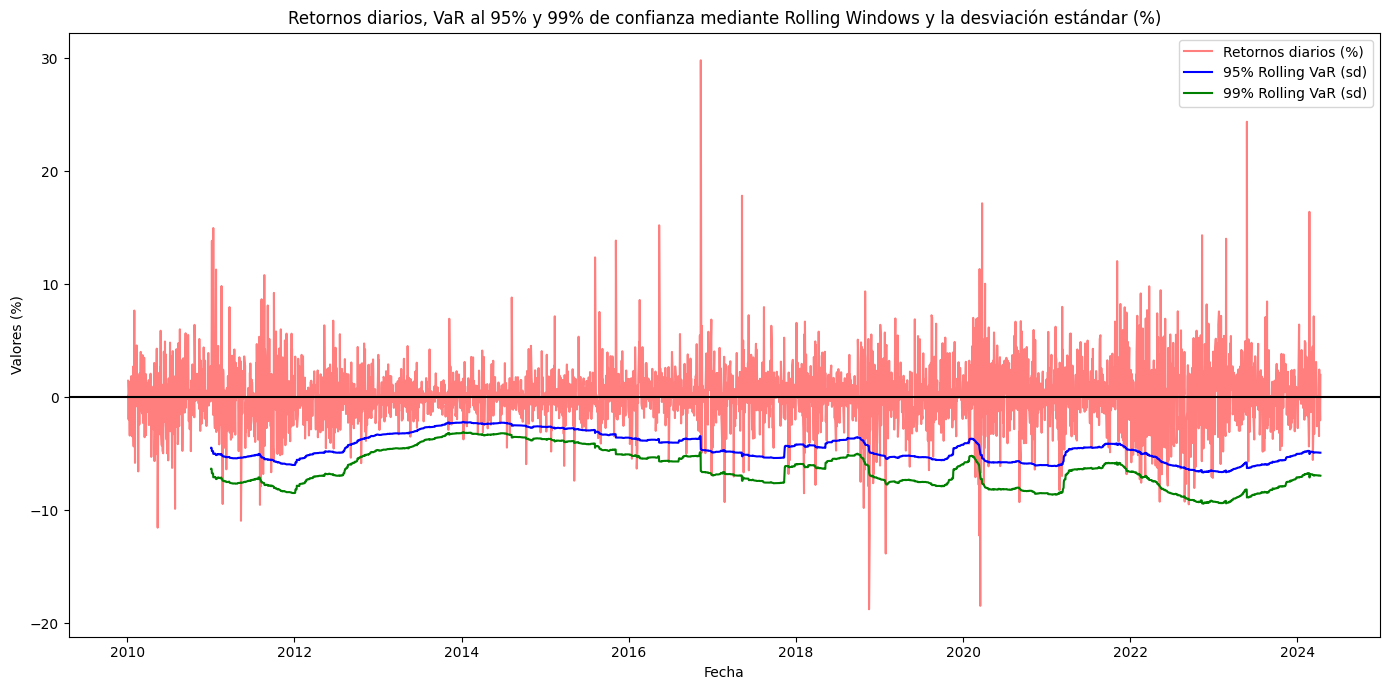

In [ ]:
plt.figure(figsize=(14, 7))

# Gráfica de los retornos diarios, convirtiéndolos a porcentaje
plt.plot(returns.index, returns * 100, label='Retornos diarios (%)', color='red', alpha=0.5)

# Agregamos el VaR calculado mediante rolling windows
plt.plot(rolling_var_sd_95.index, rolling_var_sd_95, label='95% Rolling VaR (sd)', color='blue')

# Agregamos el ES calculado mediante rolling windows
plt.plot(rolling_var_sd_99.index, rolling_var_sd_99, label = "99% Rolling VaR (sd)", color = "green")

# Agregamos linea horizontal en el cero
plt.axhline(y = 0, color = "black")

# Add a title and axis labels
plt.title('Retornos diarios, VaR al 95% y 99% de confianza mediante Rolling Windows y la desviación estándar (%)')
plt.xlabel('Fecha')
plt.ylabel('Valores (%)')

# Add a legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
# Violaciones al VaR 95
df_95 = pd.DataFrame({'returns': 100*returns, 'VaR_95': rolling_var_sd_95 }).dropna()
num_viol_95 = len(df_95[df_95["returns"] < df_95["VaR_95"]])
num_viol_95

prop_vio_95 = num_viol_95/len(df_95)

print(num_viol_95, prop_vio_95)

132 0.039532794249775384


In [ ]:
# Violaciones al VaR 95
df_99 = pd.DataFrame({'returns': 100*returns, 'VaR_99': rolling_var_sd_99 }).dropna()
num_viol_99 = len(df_99[df_99["returns"] < df_99["VaR_99"]])
num_viol_95

prop_vio_99 = num_viol_99/len(df_99)

print(num_viol_99, prop_vio_99)

41 0.012279125486672657
